## Environment setup

In [1]:
import os
os.environ['BNB_CUDA_VERSION'] = '120'

## Training data

In [2]:
def format_prompt(example):
    return f'### Question: {example["input"]}\n### Answer: {example["output"]}'

In [3]:
from datasets import load_dataset

In [4]:
train_dataset = load_dataset(
    'json',
    data_files='pandas_data_analysis_questions_train.jsonl',
    split='train'
)

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
test_dataset = load_dataset(
    'json',
    data_files='pandas_data_analysis_questions_test.jsonl',
    split='train'
)

Generating train split: 0 examples [00:00, ? examples/s]

## Log in to Hugging Face

To access models from Hugging Space you need to login. This requires an access token.

In [6]:
from huggingface_hub import notebook_login
notebook_login(new_session=True)

## Configure and download model

In [7]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [8]:
base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [9]:
model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map="auto"
)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

This can be used to load a bitsandbytes version that is different from the PyTorch CUDA version.
If this was unintended set the BNB_CUDA_VERSION variable to an empty string: export BNB_CUDA_VERSION=
If you use the manual override make sure the right libcudart.so is in your LD_LIBRARY_PATH
For example by adding the following to your .bashrc: export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:<path_to_cuda_dir/lib64



model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

## Tokenization

The maximum number of tokens for the input is 200, hence this is used for padding.  Special tokens are added at the start and end of sentences.

In [10]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [11]:
def generate_and_tokenize_prompt(prompt):
    return tokenizer(
        format_prompt(prompt),
        max_length=200,
        padding="max_length"
    )

In [12]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_test_dataset = test_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/3628 [00:00<?, ? examples/s]

Map:   0%|          | 0/372 [00:00<?, ? examples/s]

In [13]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

4000


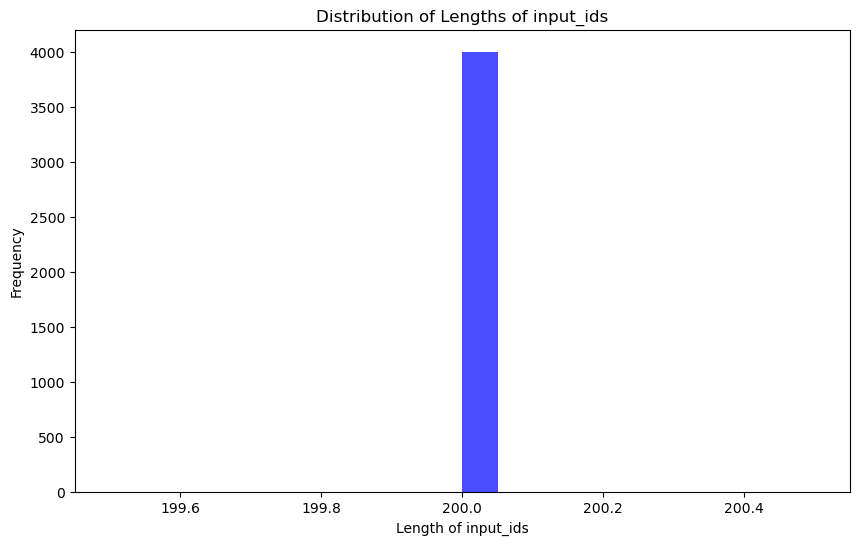

In [14]:
plot_data_lengths(tokenized_train_dataset, tokenized_test_dataset)

## Base model performance

To check the performance of the model as is, i.e., without fine-tuning, we can provide a prompt and see the result.

In [15]:
evaluation_prompt = "How to concatenate two dataframes along rows?"

Get the tokenizer for the base model.

In [16]:
evaluation_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

Tokenize the evaluation prompt.

In [17]:
model_input = evaluation_tokenizer(
    evaluation_prompt,
    return_tensors="pt"
).to("cuda")

Put the model in evaluation mode, and infer without keeping track of the gradients.

In [18]:
model.eval()
with torch.no_grad():
    print(evaluation_tokenizer.decode(
              model.generate(
                  **model_input,
                  max_new_tokens=256,
                  repetition_penalty=1.15)[0],
        skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


How to concatenate two dataframes along rows?

I have a dataframe with 10 columns and 250,000 rows. I want to add another dataframe that has the same number of columns but only 30,000 rows. The result should be a new dataframe with 10 columns and 280,000 rows.

How can this be done in pandas?

The following code does not work:

```
df = pd.concat([df1, df2], axis=0)
```

It gives me an error message saying that the indexes are different.

Is there any way to do it without reindexing both dataframes?


The result is relevant, but it is a question, not an answer to our prompt.

## Model architecture

We can visualize the architecture by simply printing it.

In [19]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNo

## PEFT: Parameter-Efficient Fine-Tuning

In [20]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
kbit_training_model = prepare_model_for_kbit_training(model)

In [21]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

peft_model = get_peft_model(kbit_training_model, config)

In [26]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [27]:
print_trainable_parameters(peft_model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.22


In [28]:
print(peft_model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k

In [29]:
from accelerate import Accelerator

In [30]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    peft_model.is_parallelizable = True
    peft_model.model_parallel = True

In [31]:
accelerator = Accelerator()

In [32]:
accelerated_model = accelerator.prepare_model(peft_model)

In [33]:
import transformers
from datetime import datetime

project = 'pandas_questions'
base_model_name = "mistral"
run_name = f'{base_model_name}-{project}'
output_dir = f'./{run_name}'
learning_rate = 2.5e-5

trainer = transformers.Trainer(
    model=accelerated_model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=2,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=learning_rate,
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

accelerated_model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/home/gjb/mambaforge/envs/ai_tools_fine_tuning/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss
25,0.436900,0.184677
50,0.166300,0.128236
75,0.136200,0.082221
100,0.097600,0.081695
125,0.080100,0.066059
150,0.071300,0.062790
175,0.066600,0.054468
200,0.051100,0.056787
225,0.053000,0.049626
250,0.046900,0.051896


/home/gjb/mambaforge/envs/ai_tools_fine_tuning/lib/python3.12/site-packages/peft/utils/save_and_load.py:227: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/gjb/mambaforge/envs/ai_tools_fine_tuning/lib/python3.12/site-packages/peft/utils/save_and_load.py:227: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/gjb/mambaforge/envs/ai_tools_fine_tuning/lib/python3.12/site-packages/peft/utils/save_and_load.py:227: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/gjb/mambaforge/envs/ai_tools_fine_tun

RuntimeError: [enforce fail at inline_container.cc:603] . unexpected pos 130979648 vs 130979536